# 第5章 决策树

## 习题5.1
&emsp;&emsp;根据表5.1所给的训练数据集，利用信息增益比（C4.5算法）生成决策树。

**解答：**  

表5.1 贷款申请样本数据表  

ID | 年龄 | 有工作 | 有自己的房子 | 信贷情况 | 类别
:-: | :-: | :-: | :-: | :-: | :-: 
1 | 青年 | 否 | 否 | 一般 | 否
2 | 青年 | 否 | 否 | 好 | 否
3 | 青年 | 是 | 否 | 好 | 是
4 | 青年 | 是 | 是 | 一般 | 是
5 | 青年 | 否 | 否 | 一般 | 否
6 | 中年 | 否 | 否 | 一般 | 否
7 | 中年 | 否 | 否 | 好 | 否
8 | 中年 | 是 | 是 | 好 | 是
9 | 中年 | 否 | 是 | 非常好 | 是
10 | 中年 | 否 | 是 | 非常好 | 是
11 | 老年 | 否 | 是 | 非常好 | 是
12 | 老年 | 否 | 是 | 好 | 是
13 | 老年 | 是 | 否 | 好 | 是
14 | 老年 | 是 | 否 | 非常好 | 是
15 | 老年 | 否 | 否 | 一般 | 否

**解答思路：**  
1. 列出C4.5的生成算法；
2. 使用sklearn的DecisionTreeClassifier类构建决策树，并使用graphviz包展示，默认是Gini，这里可以作为自编程的验证
3. 通过自编程实现C4.5算法生成决策树，并进行特征选择

**解题步骤：**

**第1步：C4.5的生成算法（书中第78页）**  

> 输入：训练数据集$D$，特征集$A$阈值$\epsilon$；  
输出：决策树$T$。  
（1）如果$D$中所有实例属于同一类$C_k$，则置$T$为单结点树，并将$C_k$作为该结点的类，返回$T$；  
（2）如果$A = \emptyset$，则置$T$为单结点树，并将$D$中实例数最大的类$C_k$作为该结点的类，返回$T$；  
（3）否则，按式$\displaystyle g_R(D,A)=\frac{g(D,A)}{H_A(D)}$计算$A$中各特征对$D$的信息增益比，选择信息增益比最大的特征$A_g$；  
（4）如果$A_g$的信息增益比小于阈值$\epsilon$，则置$T$为单结点树，并将$D$中实例数最大的类$C_k$作为该结点的类，返回$T$；  
（5）否则，对$A_g$的每一可能值$a_i$，依$A_g=a_i$将$D$分割为子集若干非空$D_i$，将$D_i$中实例数最大的类作为标记，构建子结点，由结点及其子结点构成树$T$，返回$T$；  
（6）对结点$i$，以$D_i$为训练集，以$A-\{A_g\}$为特征集，递归地调用步(1)~步(5)，得到子树$T_i$，返回$T_i$

**第2步：调用sklearn的DecisionTreeClassifier类构建决策树**

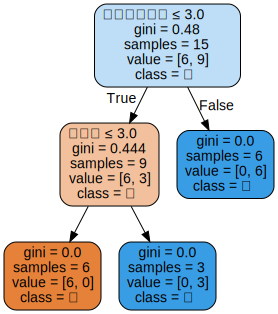

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import numpy as np
import pandas as pd

from sklearn import tree
import graphviz

features = ["年龄", "有工作", "有自己的房子", "信贷情况"]
X_train = pd.DataFrame([
    ["青年", "否", "否", "一般"],
    ["青年", "否", "否", "好"],
    ["青年", "是", "否", "好"],
    ["青年", "是", "是", "一般"],
    ["青年", "否", "否", "一般"],
    ["中年", "否", "否", "一般"],
    ["中年", "否", "否", "好"],
    ["中年", "是", "是", "好"],
    ["中年", "否", "是", "非常好"],
    ["中年", "否", "是", "非常好"],
    ["老年", "否", "是", "非常好"],
    ["老年", "否", "是", "好"],
    ["老年", "是", "否", "好"],
    ["老年", "是", "否", "非常好"],
    ["老年", "否", "否", "一般"]
])
y_train = pd.DataFrame(["否", "否", "是", "是", "否",
                        "否", "否", "是", "是", "是",
                        "是", "是", "是", "是", "否"])
class_names = [str(k) for k in np.unique(y_train)]
# 数据预处理
le_x = preprocessing.LabelEncoder()
le_x.fit(np.unique(X_train))
X_train = X_train.apply(le_x.transform)
# 调用sklearn的DecisionTreeClassifier建立决策树模型
model_tree = DecisionTreeClassifier()
# 训练模型
model_tree.fit(X_train, y_train)

# 导出决策树的可视化文件，文件格式是dot
dot_data = tree.export_graphviz(model_tree, out_file=None,
                                feature_names=features,
                                class_names=class_names,
                                filled=True, rounded=True,
                                special_characters=True)
# 使用graphviz包，对决策树进行展示
graph = graphviz.Source(dot_data)
# 可使用view方法展示决策树
# 中文乱码：需要对源码_export.py文件（文件路径：sklearn/tree/_export.py）修改，
# 在文件第451行中将helvetica改成SimSun
graph

In [2]:
# 打印决策树
tree_text = tree.export_text(model_tree, feature_names=features)
print(tree_text)

|--- 有自己的房子 <= 3.00
|   |--- 有工作 <= 3.00
|   |   |--- class: 否
|   |--- 有工作 >  3.00
|   |   |--- class: 是
|--- 有自己的房子 >  3.00
|   |--- class: 是



**第3步：自编程实现C4.5算法生成决策树**

In [3]:
import json
from collections import Counter

import numpy as np


# 节点类
class Node:
    def __init__(self, node_type, class_name, feature_name=None,
                 info_gain_ratio_value=0.0):
        # 结点类型（internal或leaf）
        self.node_type = node_type
        # 特征名
        self.feature_name = feature_name
        # 类别名
        self.class_name = class_name
        # 子结点树
        self.child_nodes = []
        # Gini指数值
        self.info_gain_ratio_value = info_gain_ratio_value

    def __repr__(self):
        return json.dumps(self, indent=3, default=lambda obj: obj.__dict__, ensure_ascii=False)

    def add_sub_tree(self, key, sub_tree):
        self.child_nodes.append({"condition": key, "sub_tree": sub_tree})

In [4]:
class MyDecisionTree:
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.tree = None

    def fit(self, train_set, y, feature_names):
        features_indices = list(range(len(feature_names)))
        self.tree = self._fit(train_set, y, features_indices, feature_names)
        return self

    # C4.5算法
    def _fit(self, train_data, y, features_indices, feature_labels):
        LEAF = 'leaf'
        INTERNAL = 'internal'
        class_num = len(np.unique(y))

        # （1）如果训练数据集所有实例都属于同一类Ck
        label_set = set(y)
        if len(label_set) == 1:
            # 将Ck作为该结点的类
            return Node(node_type=LEAF, class_name=label_set.pop())

        # （2）如果特征集为空
        # 计算每一个类出现的个数
        class_len = Counter(y).most_common()
        (max_class, max_len) = class_len[0]

        if len(features_indices) == 0:
            # 将实例数最大的类Ck作为该结点的类
            return Node(LEAF, class_name=max_class)

        # （3）按式(5.10)计算信息增益，并选择信息增益最大的特征
        max_feature = 0
        max_gda = 0
        D = y.copy()
        # 计算特征集A中各特征
        for feature in features_indices:
            # 选择训练集中的第feature列（即第feature个特征）
            A = np.array(train_data[:, feature].flat)
            # 计算信息增益
            gda = self._calc_ent_grap(A, D)
            if self._calc_ent(D) != 0:
                # 计算信息增益比
                gda /= self._calc_ent(D)
            # 选择信息增益最大的特征Ag
            if gda > max_gda:
                max_gda, max_feature = gda, feature

        # （4）如果Ag信息增益小于阈值
        if max_gda < self.epsilon:
            # 将训练集中实例数最大的类Ck作为该结点的类
            return Node(LEAF, class_name=max_class)

        max_feature_label = feature_labels[max_feature]

        # （6）移除已选特征Ag
        sub_feature_indecs = np.setdiff1d(features_indices, max_feature)
        sub_feature_labels = np.setdiff1d(feature_labels, max_feature_label)

        # （5）构建非空子集
        # 构建结点
        feature_name = feature_labels[max_feature]
        tree = Node(INTERNAL, class_name=None, feature_name=feature_name,
                    info_gain_ratio_value=max_gda)

        max_feature_col = np.array(train_data[:, max_feature].flat)
        # 将类按照对应的实例数递减顺序排列
        feature_value_list = [x[0] for x in Counter(max_feature_col).most_common()]
        # 遍历Ag的每一个可能值ai
        for feature_value in feature_value_list:
            index = []
            for i in range(len(y)):
                if train_data[i][max_feature] == feature_value:
                    index.append(i)

            # 递归调用步（1）~步（5），得到子树
            sub_train_set = train_data[index]
            sub_train_label = y[index]
            sub_tree = self._fit(sub_train_set, sub_train_label, sub_feature_indecs, sub_feature_labels)
            # 在结点中，添加其子结点构成的树
            tree.add_sub_tree(feature_value, sub_tree)

        return tree

    # 计算数据集x的经验熵H(x)
    def _calc_ent(self, x):
        x_value_list = set([x[i] for i in range(x.shape[0])])
        ent = 0.0
        for x_value in x_value_list:
            p = float(x[x == x_value].shape[0]) / x.shape[0]
            logp = np.log2(p)
            ent -= p * logp

        return ent

    # 计算条件熵H(y/x)
    def _calc_condition_ent(self, x, y):
        x_value_list = set([x[i] for i in range(x.shape[0])])
        ent = 0.0
        for x_value in x_value_list:
            sub_y = y[x == x_value]
            temp_ent = self._calc_ent(sub_y)
            ent += (float(sub_y.shape[0]) / y.shape[0]) * temp_ent

        return ent

    # 计算信息增益
    def _calc_ent_grap(self, x, y):
        base_ent = self._calc_ent(y)
        condition_ent = self._calc_condition_ent(x, y)
        ent_grap = base_ent - condition_ent

        return ent_grap

    def __repr__(self):
        return str(self.tree)

In [5]:
# 表5.1的训练数据集
feature_names = np.array(["年龄", "有工作", "有自己的房子", "信贷情况"])
X_train = np.array([
    ["青年", "否", "否", "一般"],
    ["青年", "否", "否", "好"],
    ["青年", "是", "否", "好"],
    ["青年", "是", "是", "一般"],
    ["青年", "否", "否", "一般"],
    ["中年", "否", "否", "一般"],
    ["中年", "否", "否", "好"],
    ["中年", "是", "是", "好"],
    ["中年", "否", "是", "非常好"],
    ["中年", "否", "是", "非常好"],
    ["老年", "否", "是", "非常好"],
    ["老年", "否", "是", "好"],
    ["老年", "是", "否", "好"],
    ["老年", "是", "否", "非常好"],
    ["老年", "否", "否", "一般"]
])
y = np.array(["否", "否", "是", "是", "否",
              "否", "否", "是", "是", "是",
              "是", "是", "是", "是", "否"])

dt_tree = MyDecisionTree(epsilon=0.1)
dt_tree.fit(X_train, y, feature_names)
dt_tree

{
   "node_type": "internal",
   "feature_name": "有自己的房子",
   "class_name": null,
   "child_nodes": [
      {
         "condition": "否",
         "sub_tree": {
            "node_type": "internal",
            "feature_name": "年龄",
            "class_name": null,
            "child_nodes": [
               {
                  "condition": "否",
                  "sub_tree": {
                     "node_type": "leaf",
                     "feature_name": null,
                     "class_name": "否",
                     "child_nodes": [],
                     "info_gain_ratio_value": 0.0
                  }
               },
               {
                  "condition": "是",
                  "sub_tree": {
                     "node_type": "leaf",
                     "feature_name": null,
                     "class_name": "是",
                     "child_nodes": [],
                     "info_gain_ratio_value": 0.0
                  }
               }
            ],
            "info_

## 习题5.2
&emsp;&emsp;已知如表5.2所示的训练数据，试用平方误差损失准则生成一个二叉回归树。  
表5.2 训练数据表  

| $x_i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |  
| - | - | - | - | - | - | - | - | - | - | - |  
| $y_i$ | 4.50 | 4.75 | 4.91 | 5.34 | 5.80 | 7.05 | 7.90 | 8.23 | 8.70 | 9.00

**解答：**

**解答思路：**
1. 根据书中第81页平方误差损失准则，列出最小二乘回归树生成算法（算法5.5）；
2. 编写代码，实现算法，并用表5.2训练数据进行验证。

**解题步骤：**

**第1步：算法5.5的最小二乘回归树生成算法（书中第82页）**

> &emsp;&emsp;决策树的生成就是递归地构建二叉决策树的过程，对回归树用平方误差最小化准则，对分类树用基尼指数（Gini index）最小化准则，进行特征选择，生成二叉树。
> 
> 算法5.5（最小二乘回归树生成算法）  
输入：训练数据集$D$  
输出：回归树$f(x)$  
在训练数据集所在的输入空间中，递归地将每个区域划分为两个子区域并决定每个子区域上的输出值，构建二叉决策树；  
(1)选择最优切分变量$j$与切分点$s$，求解
> $$
\min_{j,s} \left[ \min_{c_1} \sum_{x_i \in R_1(j,s)} (y_i - c_1)^2 + \min_{c_2} \sum_{x_i \in R_2(j,s)} (y_i - c_2)^2\right]
$$
> 遍历变量$j$，对固定的切分变量$j$扫描切分点$s$，选择使得上式达到最小值的对$(j,s)$  
(2)用选定的对$(j,s)$划分区域并决定相应的输出值：
> $$
R_1(j,s)=\{x|x^{(j)}\leqslant s\}, R_2(j,s)=\{x|x^{(j)} > s\} \\ 
\hat{c}_m = \frac{1}{N_m} \sum_{x_i \in R_m(j,s)} y_i, x \in R_m, m=1,2 
$$
> (3)继续对两个子区域调用步骤(1),(2)，直至满足停止条件  
(4)将输入空间划分为$M$个区域$R_1,R_2,\cdots,R_M$，生成决策树：
> $$
f(x)=\sum_{m=1}^M \hat{c}_m I(x \in R_m)
$$

**第2步：编写代码，实现算法，并用表5.2训练数据进行验证**

In [6]:
import json

import numpy as np


# 节点类
class Node:
    def __init__(self, value, feature, left=None, right=None):
        self.value = value.tolist()
        self.feature = feature.tolist()
        self.left = left
        self.right = right

    def __repr__(self):
        return json.dumps(self, indent=3, default=lambda obj: obj.__dict__, ensure_ascii=False)

In [7]:
class MyLeastSquareRegTree:
    def __init__(self, train_X, y, epsilon):
        # 训练集特征值
        self.x = train_X
        # 类别
        self.y = y
        # 特征总数
        self.feature_count = train_X.shape[1]
        # 损失阈值
        self.epsilon = epsilon
        # 回归树
        self.tree = None

    def _fit(self, x, y, feature_count):
        # （1）选择最优切分点变量j与切分点s，得到选定的对(j,s)，并解得c1，c2
        (j, s, minval, c1, c2) = self._divide(x, y, feature_count)
        # 初始化树
        tree = Node(feature=j, value=x[s, j], left=None, right=None)
        # 用选定的对(j,s)划分区域，并确定响应的输出值
        if minval < self.epsilon or len(y[np.where(x[:, j] <= x[s, j])]) <= 1:
            tree.left = c1
        else:
            # 对左子区域调用步骤（1）、（2）
            tree.left = self._fit(x[np.where(x[:, j] <= x[s, j])],
                                  y[np.where(x[:, j] <= x[s, j])],
                                  self.feature_count)
        if minval < self.epsilon or len(y[np.where(x[:, j] > s)]) <= 1:
            tree.right = c2
        else:
            # 对右子区域调用步骤（1）、（2）
            tree.right = self._fit(x[np.where(x[:, j] > x[s, j])],
                                   y[np.where(x[:, j] > x[s, j])],
                                   self.feature_count)
        return tree

    def fit(self):
        self.tree = self._fit(self.x, self.y, self.feature_count)
        return self

    @staticmethod
    def _divide(x, y, feature_count):
        # 初始化损失误差
        cost = np.zeros((feature_count, len(x)))
        # 公式5.21
        for i in range(feature_count):
            for k in range(len(x)):
                # k行i列的特征值
                value = x[k, i]
                y1 = y[np.where(x[:, i] <= value)]
                c1 = np.mean(y1)
                y2 = y[np.where(x[:, i] > value)]
                if len(y2) == 0:
                    c2 = 0
                else:
                    c2 = np.mean(y2)
                y1[:] = y1[:] - c1
                y2[:] = y2[:] - c2
                cost[i, k] = np.sum(y1 * y1) + np.sum(y2 * y2)
        # 选取最优损失误差点
        cost_index = np.where(cost == np.min(cost))
        # 所选取的特征
        j = cost_index[0][0]
        # 选取特征的切分点
        s = cost_index[1][0]
        # 求两个区域的均值c1,c2
        c1 = np.mean(y[np.where(x[:, j] <= x[s, j])])
        c2 = np.mean(y[np.where(x[:, j] > x[s, j])])
        return j, s, cost[cost_index], c1, c2

    def __repr__(self):
        return str(self.tree)

In [8]:
train_X = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]).T
y = np.array([4.50, 4.75, 4.91, 5.34, 5.80, 7.05, 7.90, 8.23, 8.70, 9.00])

model_tree = MyLeastSquareRegTree(train_X, y, epsilon=0.2)
model_tree.fit()
model_tree

{
   "value": 5,
   "feature": 0,
   "left": {
      "value": 3,
      "feature": 0,
      "left": 4.72,
      "right": 5.57
   },
   "right": {
      "value": 7,
      "feature": 0,
      "left": {
         "value": 6,
         "feature": 0,
         "left": 7.05,
         "right": 7.9
      },
      "right": {
         "value": 8,
         "feature": 0,
         "left": 8.23,
         "right": 8.85
      }
   }
}

根据上面程序的输出，可得到用平方误差损失准则生成一个二叉回归树：$$f(x)=\begin{cases}
4.72 & x \le 3\\
5.57 & 3 < x \le 5\\
7.05 & 5 < x \le 6\\
7.9 & 6 < x \le 7 \\
8.23 & 7 < x \le 8\\
8.85 & x > 8\\
\end{cases}$$

## 习题5.3

&emsp;&emsp;证明 CART 剪枝算法中，当$\alpha$确定时，存在唯一的最小子树$T_{\alpha}$使损失函数$C_{\alpha}(T)$最小。

**解答：**

**解答思路：**
1. 列出CART剪枝算法；
2. 列出树的剪枝算法；
3. 采用反证法，假设存在两棵子树使得损失函数最小。

**解答步骤：**

**第1步：CART剪枝算法（书中第87页）**
> 输入：CART算法生成的决策树$T_0$；  
输出：最优决策树$T_\alpha$。  
> （1）设$k=0,T=T_0$。  
（2）设$\alpha=+\infty$。  
（3）自下而上地对各内部结点$t$计算$C(T_t)$,$|T_t|$，以及
> $$
g(t)=\cfrac{C(t)-C(T_t)}{|T_t|-1} \\
\alpha = \min(\alpha,g(t))
$$
> 这里，$T_t$表示以$t$为根结点的子树，$C(T_t)$是对训练数据的预测误差，$|T_t|$是$T_t$的叶结点个数。  
（4）对$g(t)=\alpha$的内部结点$t$进行剪枝，并对叶结点$t$以多数表决法决定其类，得到树$T$。  
（5）设$k=k+1,\alpha_k=\alpha,T_k=T$。  
（6）如果$T_k$不是由根节点和两个叶结点组成的树，则回到步骤（2），否则$T_k=T_n$。  
（7）采用交叉验证法在子树序列从$T_0,T_1,\cdots,T_n$中选取最优子树$T_{\alpha}$。

**第2步：树的剪枝算法（书中第79页）**
> 输入：生成算法产生的整个树$T$，参数$\alpha$；  
输出：修剪后的子树$T_\alpha$。  
（1）计算每个结点的经验熵。  
（2）递归地从树的叶结点向上回缩。  
&emsp;&emsp;设一组叶结点回缩到其父结点之前与之后的整体树分别为$T_B$与$T_A$，其对应的损失函数分别是$C_\alpha(T_B)$与$C_\alpha(T_A)$，如果
>$$
C_\alpha(T_A) \leqslant C_\alpha(T_B)
$$
> 则进行剪枝，即将父结点变为新的叶结点。  
（3）返回（2），直至不能继续为止，得到损失函数最小的子树$T_\alpha$。

**第3步：采用反证法，假设存在两棵子树使得损失函数最小**  

&emsp;&emsp;从第1、2步可得到以下结论：
1. 内部节点是否剪枝只与以该节点为根节点的子树有关；
2. 当$C_\alpha(t) < C_\alpha(T_t)$时，对以结点$t$为根节点的子树进行剪枝。

<br/><center>
<img src="./images/5-1-prune.png" style="zoom: 50%;"><br/><div style="color:orange; border-bottom: 1px solid #d9d9d9;display: inline-block;color: #000;padding: 2px;">图5.1 树$T_1$存在两个最优子树$T_2,T_3$</div></center>

&emsp;&emsp;如图5.1所示，整个树$T_1$有两个子树$T_2$和$T_3$，其剪枝位置分别为$t_2$和$t_3$，假设两棵子树都是$T_1$的最优子树，使得损失函数最小。则满足以下等式：
$$
C_{\alpha}(T_2)=C_{\alpha}(T_3) 
$$ 
&emsp;&emsp;根据子树$T_2$的剪枝位置是$t_2$，可得
$$
C_{\alpha}(t_2)<C_{\alpha}(T_2) 
$$
&emsp;&emsp;根据子树$T_3$的剪枝位置是$t_3$，可得
$$
C_{\alpha}(t_3)<C_{\alpha}(T_3)
$$
&emsp;&emsp;由上面公式可得：
$$
C_{\alpha}(t_2)<C_{\alpha}(T_3) \\
C_{\alpha}(t_3)<C_{\alpha}(T_2)
$$
&emsp;&emsp;根据上述公式，可知$T_2$和$T_3$都可以进一步剪枝，剪枝之后的子树记作$T_4$：

<br/><center>
<img src="./images/5-2-prune-T4.png" style="zoom: 50%;"><br/><div style="color:orange; border-bottom: 1px solid #d9d9d9;display: inline-block;color: #000;padding: 2px;">图5.2 剪枝后的子树$T_4$</div></center>

&emsp;&emsp;因此，如果存在两棵以上的最优子树，其中一棵树总能找到一个来自另一棵子树的剪枝点，使得整体损失进一步下降，所以只能存在唯一的最小子树使得损失函数最小，得证。

## 习题5.4

&emsp;&emsp;证明 CART 剪枝算法中求出的子树序列$\{T_0,T_1,\cdots,T_n\}$分别是区间$\alpha \in [\alpha_i,\alpha_{i+1})$的最优子树$T_{\alpha}$，这里$i=0,1,\cdots,n,0=\alpha_0 < \alpha_1 < \cdots, \alpha_n < +\infty$。

**解答：**

**解答思路：**
1. 对题目重新进行表述；
2. 证明当$\alpha=0$和$\alpha= + \infty$时的最优子树；
3. 证明$T_1$为区间$[\alpha_1,\alpha_2)$的最优子树。

**解答步骤：**

**第1步：对题目重新表述**  
&emsp;&emsp;原结论可以表述为：将$\alpha$从$0$增大到$+\infty$（即$0=\alpha_0<\alpha_1<\cdots<\alpha_n < +\infty$），在每个区间$[\alpha_i,\alpha_{i+1})$中，其中$i=0,1,\ldots,n$，子树$T_i$是该区间里最优的。

**第2步：证明当$\alpha=0$和$\alpha= + \infty$时的最优子树**

根据书中第85页：
> &emsp;&emsp;当$\alpha$大的时候，最优子树$T_\alpha$偏小；当$\alpha$小的时候，最优子树$T_\alpha$偏大。极端情况，当$\alpha=0$时，整体树是最优的。当$\alpha \rightarrow +\infty$时，根结点组成的单结点树是最优的。

**第3步：证明$T_1$是区间$[\alpha_1, \alpha_2)$的最优子树**

&emsp;&emsp;根据《Classification and Regression Trees》书中第10.2节的定理10.7：
> THEOREM 10.7. Every tree T has a unique smallest optimally pruned subtree $T(\alpha)$. Let T be a nontrivial tree having root $t_1$ and primary branches $T_L$ and $T_R$. Then $$R_{\alpha}(T(\alpha)) = \min[R_{\alpha}(t_1), R_{\alpha}(T_L(\alpha))+R_{\alpha}(T_R(\alpha))]$$ If $R_{\alpha}(t_1) \leqslant R_{\alpha}(T_L(\alpha))+R_{\alpha}(T_R(\alpha))$, then $T(\alpha)=\{t_1\}$; otherwise, $T(\alpha) = \{t_1\} \cup T_L(\alpha) \cup T_R(\alpha)$.

&emsp;&emsp;根据该书的符号描述，其中：
1. $T(\alpha)$表示，在$\alpha$条件时，树$T$的最小最优剪枝子树
2. $R_{\alpha}(T(\alpha))$表示，在$\alpha$条件时，$T(\alpha)$的损失值，即$C_{\alpha}(T_{\alpha})$

&emsp;&emsp;定理10.7表示，树$T$分为根结点$t_1$、左子树$T_L$和右子树$T_R$，计算在$\alpha$条件时的最优子树的损失，可取$R_{\alpha}(t_1)$和$R_{\alpha}(T_L(\alpha))+R_{\alpha}(T_R(\alpha))$中的最小值，并且$T(\alpha)$满足以下公式：
$$
T(\alpha) = \left\{ \begin{array}{l}
\{t_1 \}, \quad R_{\alpha}(t_1) \leqslant R_{\alpha}(T_L(\alpha))+R_{\alpha}(T_R(\alpha)) \\
\{t_1\} \cup T_L(\alpha) \cup T_R(\alpha), \quad \text{otherwise}
\end{array}\right.
$$

&emsp;&emsp;根据定理10.7，可以得到该书定理10.9的第一个推论：
> THEOREM 10.9.   
(i) If $\alpha_2 \geqslant \alpha_1$, then $T(α2) \preceq T(α1)$.

&emsp;&emsp;定理10.9(i)表示，当$\alpha_2 \geqslant \alpha_1$时，树$T$在$\alpha_2$条件下的最优子树一定是树$T$在$\alpha_1$条件下的最优子树的子树。

&emsp;&emsp;根据CART剪枝算法和定理10.9，可知（见该书的第368页）：
1. 当$\alpha \geqslant \alpha_1$时，$T_0(\alpha)=T_1$
2. 当$\alpha_1 \leqslant \alpha < \alpha_2$时，$T_0(\alpha) \preceq T_0(\alpha_1) = T_1 \preceq T_0 $

&emsp;&emsp;所以，$T_0(\alpha)=T_1(\alpha)=T_1$，该式说明$T_1$是区间$[\alpha_1, \alpha_2)$的最优子树。  

&emsp;&emsp;依次类推，子树$T_i$是区间$[\alpha_i,\alpha_{i+1})$里最优的，原结论得证。